In [ ]:
%%capture
!pip install jcopml

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier

from jcopml.plot import plot_missing_value

In [ ]:
df_test=pd.read_csv("content/test.csv", index_col="id", parse_dates=['time'])
df_test_hourly=pd.read_csv("/content/test_hourly.csv", parse_dates=['time'])
df_test_hourly.dropna(inplace = True)

df_train=pd.read_csv("/content/train.csv", parse_dates=['time'])
df_train.dropna(subset = ["rain_sum (mm)"],inplace = True)
df_train_hourly = pd.read_csv("/content/train_hourly.csv",parse_dates=  ["time"])
df_train_hourly.dropna(inplace = True)
df_test.head()

,time,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,sunrise,sunset,shortwave_radiation_sum(MJ/m²),snowfall_sum(cm),windspeed_10m_max(km/h),windgusts_10m_max(km/h),winddirection_10m_dominant,et0_fao_evapotranspiration(mm),elevation,city
id,,,,,,,,,,,,,,,
0,2021-08-02,32.3,25.3,38.2,29.6,2021-08-02T05:39,2021-08-02T17:30,20.79,0.0,7.6,16.9,134.0,4.45,0,su
1,2021-08-03,31.7,25.5,37.4,30.3,2021-08-03T05:39,2021-08-03T17:30,20.01,0.0,10.2,21.6,131.0,4.32,0,su
2,2021-08-04,32.6,25.7,37.1,30.8,2021-08-04T05:39,2021-08-04T17:30,20.89,0.0,17.3,32.4,116.0,4.73,0,su
3,2021-08-05,32.0,25.7,36.8,31.1,2021-08-05T05:39,2021-08-05T17:30,22.19,0.0,15.8,29.2,115.0,4.96,0,su
4,2021-08-06,31.9,26.3,36.0,31.6,2021-08-06T05:38,2021-08-06T17:30,21.84,0.0,20.2,36.7,106.0,4.99,0,su


In [ ]:

dict_agg = {}
for col in df_train_hourly.columns:
    if col not in ["time","city"]:
        dict_agg[col] = ["mean","std","min","max"]
def agg_data(df_hourly,df,dict_agg,freq):
    data = df_hourly.copy()
    data = data.groupby(["city",pd.Grouper(key="time",freq=freq)]).agg(dict_agg)
    data = data.reset_index()
    data["time_hour"] = data['time']
    data["time_hour"] = data['time_hour'].dt.hour
    data['time'] = data['time'].dt.date
    data.set_index(["time","city","time_hour"],inplace = True)
    #
    data = data.unstack(level=2)
    data.columns = data.columns = [x[0] + "_" + x[1] + "_" +str(x[2]) for x in data.columns.ravel()]
    data = data.reset_index()
    data['time'] = pd.to_datetime(data['time'])
    df = df.merge(data, on=["time","city"], how="left")
    return df

# New Section

In [ ]:
df_train_merge = agg_data(df_train_hourly,df_train,dict_agg,"12H")
df_test_merge = agg_data(df_test_hourly,df_test,dict_agg, "12H")
df_train_merge.head()

<ipython-input-88-5d7a8167d7d8>:15: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  data.columns = data.columns = [x[0] + "_" + x[1] + "_" +str(x[2]) for x in data.columns.ravel()]


KeyError: ignored

## Exploratory Data Analyse (EDA)

# New Section

In [ ]:
df_test_merge.info( )

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4972 entries, 0 to 4971
Columns: 255 entries, time to soil_moisture_100_to_255cm (m³/m³)_max_12
dtypes: datetime64[ns](1), float64(250), int64(1), object(3)
memory usage: 9.7+ MB


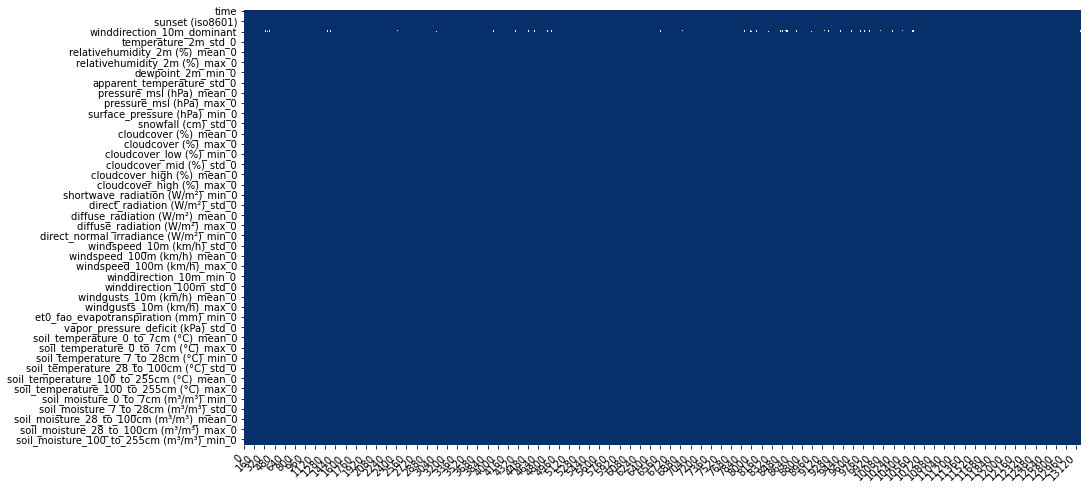

In [ ]:
plot_missing_value(df_train_merge)

### Target

In [ ]:
df_train_merge["windgusts_10m_max (km/h)"].value_counts()

24.8    299
23.8    289
22.7    287
23.4    280
25.9    274
       ... 
76.3      1
72.4      1
89.6      1
90.7      1
7.6       1
Name: windgusts_10m_max (km/h), Length: 202, dtype: int64

In [ ]:
df_train_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13198 entries, 0 to 13197
Columns: 256 entries, time to soil_moisture_100_to_255cm (m³/m³)_max_12
dtypes: datetime64[ns](1), float64(251), int64(1), object(3)
memory usage: 26.4+ MB


In [ ]:
df_test_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4972 entries, 0 to 4971
Columns: 255 entries, time to soil_moisture_100_to_255cm (m³/m³)_max_12
dtypes: datetime64[ns](1), float64(250), int64(1), object(3)
memory usage: 9.7+ MB


In [ ]:
## Shuffle
X = df_train_merge.drop(columns="rain_sum (mm)")
y = df_train_merge["rain_sum (mm)"]

X_train, y_train = X[X.time < "2021-01-01"], y[X.time < "2021-01-01"]
X_test, y_test = X[X.time >= "2021-01-01"], y[X.time >= "2021-01-01"]

In [ ]:
from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [ ]:
#COMMON
preprocessor = ColumnTransformer([
('numeric', num_pipe(transform = "yeo-johnson",impute = "mean"), X_train.select_dtypes("number").columns.tolist() ),
    ('categoric', cat_pipe(encoder='ordinal'), ["city"]),
])

In [ ]:
#KNN
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', KNeighborsregressor())
])

In [ ]:
#RANDOMIZED SEARCH CV
from sklearn.model_selection import RandomizedSearchCV,KFold
from jcopml.tuning import random_search_params as rsp
from sklearn.metrics import mean_squared_error
lgbm_params = {}

cv = KFold(shuffle = True,random_state = 42,n_splits = 5)
#rsp.knn_params -> knn
#rsp.svm_params -> svm
model = RandomizedSearchCV(pipeline, rsp.knn_params, cv=cv, scoring='neg_mean_squared_error', n_iter=1, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(mean_squared_error(y_train, model.predict(X_train)), model.best_score_, mean_squared_error(y_test,model.predict(X_test)))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{}
5.247195204331551 -19.008810008760484 14.580620452220973
